In [1]:
import proper
import matplotlib.pyplot as plt
from heeps.util.img_processing import resize_img, crop_img, pad_img
from astropy.io import fits
import numpy as np
%matplotlib inline

In [2]:
# define pixel scale on a 1023 pupil image size
ngrid = 1024
pscale = 39.9988/(ngrid - 1)

# create pupil using PROPER tools
def create_pupil(pupil_img_size, diam_ext, diam_int, spi_width, nhr=ngrid, spi_angles=[0,60,120]):
    nhr_size = pupil_img_size*nhr/(nhr-1)
    wf_tmp = proper.prop_begin(nhr_size, 1, nhr, diam_ext/nhr_size) 
    if diam_ext > 0:
        proper.prop_circular_aperture(wf_tmp, 1, NORM=True)
    if diam_int > 0:
        proper.prop_circular_obscuration(wf_tmp, diam_int/diam_ext, NORM=True)
    if spi_width > 0:
        for angle in spi_angles:
            proper.prop_rectangular_obscuration(wf_tmp, 2*spi_width/diam_ext, 2, ROTATION=angle, NORM=True)
    return proper.prop_get_amplitude(wf_tmp)

## without spiders

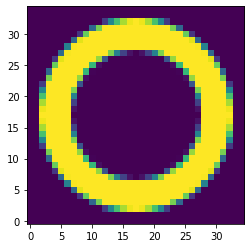

In [3]:
pup = create_pupil(1023*pscale, 31*pscale, 21*pscale, 0)
plt.figure(), plt.imshow(crop_img(pup, 35), origin='lower');
fits.writeto('pup.fits', np.float32(pup), overwrite=True)

## with spiders

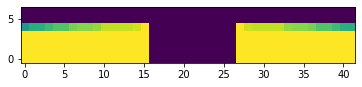

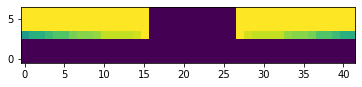

In [4]:
pup = create_pupil(1023*pscale, 1019*pscale, 0, 11*pscale)
# zoom to pupil edges
c = ngrid//2
w = 7
pup_bot = pup[:w,c-3*w:c+3*w]
pup_top = pup[-w:,c-3*w:c+3*w]
plt.figure(), plt.imshow(pup_top, origin='lower');
plt.figure(), plt.imshow(pup_bot, origin='lower');
fits.writeto('spi.fits', np.float32(pup), overwrite=True)
fits.writeto('spi_bot.fits', np.float32(pup_bot), overwrite=True)
fits.writeto('spi_top.fits', np.float32(pup_top), overwrite=True)

### Test beam radius normalization

In [5]:
nhr = 2**10
pupil_img_size = 3.0
diam_ext = 2.0
diam_int = 1.0
spi_width = 0.54
spi_angles = [0, 60, 120]
dx, dy = 0, 0
npupil = 11
ngrid = 1024
beam_diam = 1e2
beam_ratio = npupil/ngrid*(diam_ext/pupil_img_size)
print(beam_ratio, beam_ratio*ngrid)

0.007161458333333333 7.333333333333333


100.0

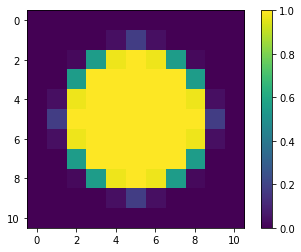

In [6]:
R_NORM = 1#pupil_img_size/diam_ext
wf_tmp = proper.prop_begin(beam_diam, 1, ngrid, beam_ratio)
proper.prop_circular_aperture(wf_tmp, R_NORM, NORM=True)
plt.imshow(crop_img(proper.prop_get_amplitude(wf_tmp), npupil)); plt.colorbar()
wf_tmp._diam

100.0

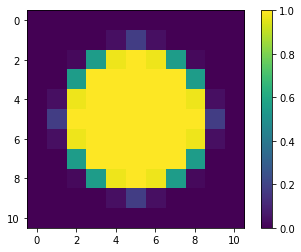

In [7]:
RADIUS = R_NORM*beam_diam/2
# ATTENTION!! if NORM=False, use the RADIUS (not diameter)
wf_tmp = proper.prop_begin(beam_diam, 1, ngrid, beam_ratio)
proper.prop_circular_aperture(wf_tmp, RADIUS, NORM=False)
plt.imshow(crop_img(proper.prop_get_amplitude(wf_tmp), npupil)); plt.colorbar()
wf_tmp._diam

### Test grid sampling

nhr_size = 3.002932551319648
beam_diam = 2.0, grid_sampling = 0.27272727272727276
verif : 2.0, 0.2727272727272727


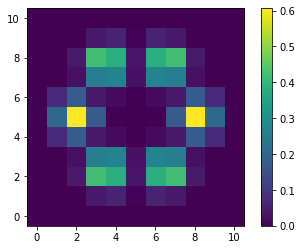

In [8]:
beam_ratio = npupil/ngrid*(diam_ext/pupil_img_size)
wf2 = proper.prop_begin(diam_ext, 1, ngrid, beam_ratio)
nhr = max(nhr, npupil)
nhr += nhr % 2
nhr_size = pupil_img_size*nhr/(nhr-1)
print('nhr_size = %s'%nhr_size)
# create pupil using PROPER tools
wf_tmp = proper.prop_begin(1, 1, nhr, diam_ext/nhr_size) 
if diam_ext > 0:
    proper.prop_circular_aperture(wf_tmp, 1, dx, dy, NORM=True)
if diam_int > 0:
    proper.prop_circular_obscuration(wf_tmp, diam_int/diam_ext, dx, 
        dy, NORM=True)
if spi_width > 0:
    for angle in spi_angles:
        proper.prop_rectangular_obscuration(wf_tmp, 2*spi_width/diam_ext, 2,
            dx, dy, ROTATION=angle, NORM=True)
pup = proper.prop_get_amplitude(wf_tmp)
# crop the pupil to odd size (nhr-1), and resize to npupil
pup = pup[1:,1:]
pup = resize_img(pup, npupil)
proper.prop_multiply(wf2, pad_img(pup, ngrid))
A = crop_img(proper.prop_get_amplitude(wf2), npupil)
plt.imshow(A, origin='lower'); plt.colorbar()
A[5,2]
print('beam_diam = %s, grid_sampling = %s'%(wf2._diam, wf2._dx))
print('verif : %s, %s'%(diam_ext, pupil_img_size/npupil))

